In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (8,5)


In [2]:
trader_df = pd.read_csv(
    r"D:\projects\trader-behavior-vs-market-sentiment\data\raw\historical_data.csv"
)

sentiment_df = pd.read_csv(
    r"D:\projects\trader-behavior-vs-market-sentiment\data\raw\fear_greed_index.csv"
)

print("Trader data shape:", trader_df.shape)
print("Sentiment data shape:", sentiment_df.shape)


Trader data shape: (211224, 16)
Sentiment data shape: (2644, 4)


In [3]:
# Trader data
trader_df.columns = (
    trader_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Sentiment data
sentiment_df.columns = (
    sentiment_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

print(trader_df.columns)
print(sentiment_df.columns)


Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [4]:
trader_df['timestamp_ist'] = pd.to_datetime(
    trader_df['timestamp_ist'], errors='coerce'
)

trader_df['date'] = trader_df['timestamp_ist'].dt.date


In [5]:
sentiment_df['date'] = pd.to_datetime(
    sentiment_df['date'], errors='coerce'
).dt.date

sentiment_df.rename(
    columns={'classification': 'sentiment'},
    inplace=True
)


In [6]:
trader_df = trader_df[
    [
        'account',
        'coin',
        'side',
        'direction',
        'execution_price',
        'size_usd',
        'closed_pnl',
        'fee',
        'date'
    ]
]


In [7]:
df = pd.merge(
    trader_df,
    sentiment_df[['date', 'sentiment']],
    on='date',
    how='left'
)

df = df.dropna(subset=['sentiment'])

df.head()


,account,coin,side,direction,execution_price,size_usd,closed_pnl,fee,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,Buy,7.9769,7872.16,0.0,0.345404,2024-02-12,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,Buy,7.9800,127.68,0.0,0.005600,2024-02-12,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,Buy,7.9855,1150.63,0.0,0.050431,2024-02-12,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,Buy,7.9874,1142.04,0.0,0.050043,2024-02-12,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,Buy,7.9894,69.75,0.0,0.003055,2024-02-12,Greed


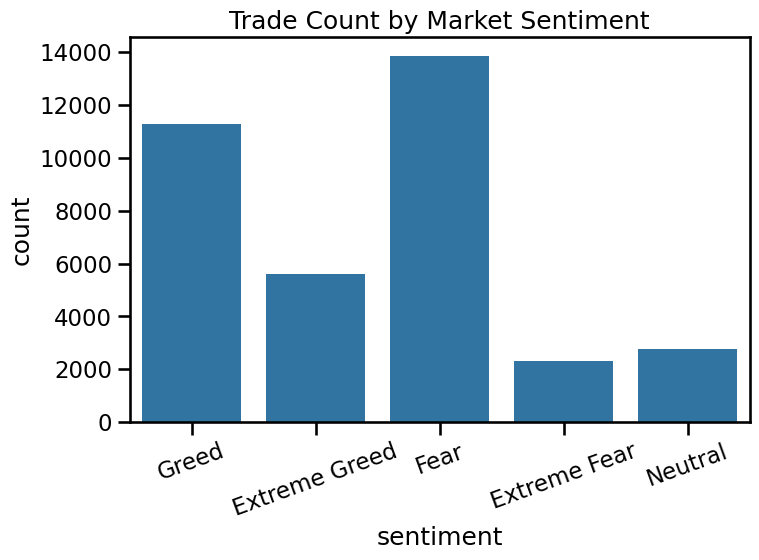

In [8]:
sns.countplot(x='sentiment', data=df)
plt.title("Trade Count by Market Sentiment")
plt.xticks(rotation=20)
plt.show()


In [9]:
sentiment_summary = df.groupby('sentiment')['closed_pnl'].agg(
    trades='count',
    avg_pnl='mean',
    total_pnl='sum'
).reset_index()

sentiment_summary


,sentiment,trades,avg_pnl,total_pnl
0,Extreme Fear,2326,1.891632,4.399937e+03
1,Extreme Greed,5621,205.816345,1.156894e+06
2,Fear,13869,128.287950,1.779226e+06
3,Greed,11292,53.988003,6.096325e+05
4,Neutral,2756,27.088803,7.465674e+04


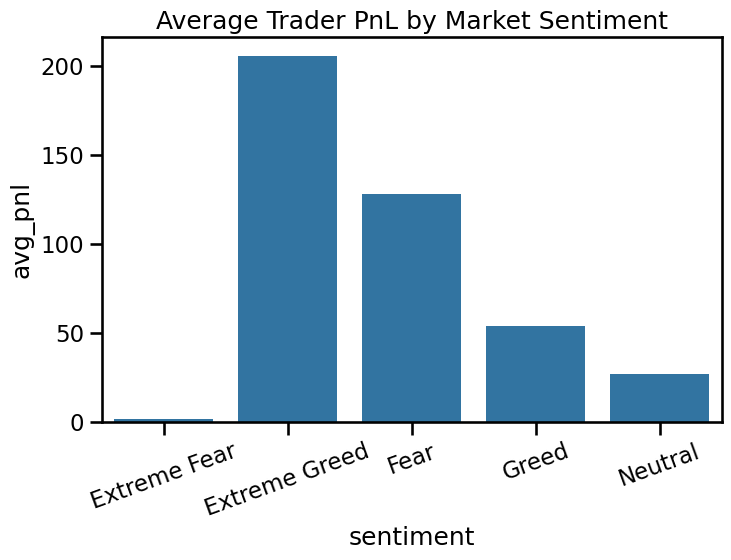

In [10]:
sns.barplot(x='sentiment', y='avg_pnl', data=sentiment_summary)
plt.title("Average Trader PnL by Market Sentiment")
plt.xticks(rotation=20)
plt.show()


In [11]:
side_pnl = df.groupby(['sentiment', 'side'])['closed_pnl'].mean().reset_index()
side_pnl


,sentiment,side,closed_pnl
0,Extreme Fear,BUY,-3.248825
1,Extreme Fear,SELL,7.076480
2,Extreme Greed,BUY,9.047055
3,Extreme Greed,SELL,288.350131
4,Fear,BUY,210.426466
5,Fear,SELL,36.824047
6,Greed,BUY,15.661324
7,Greed,SELL,89.201657
8,Neutral,BUY,12.484274
9,Neutral,SELL,35.669805


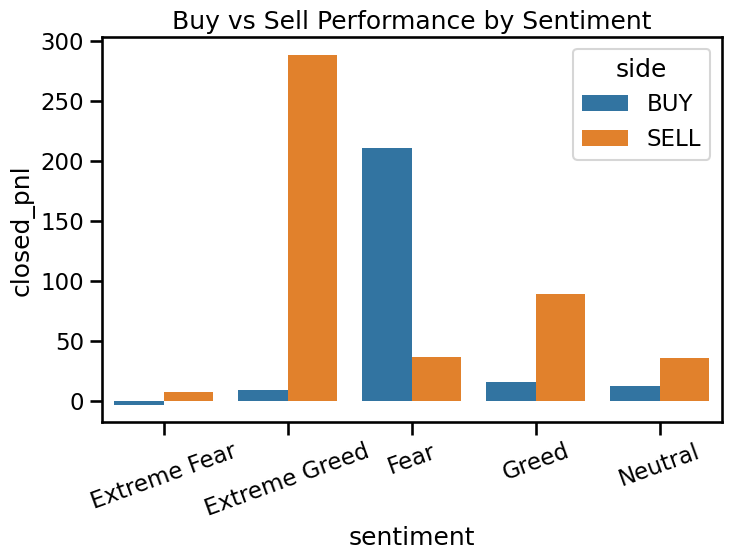

In [12]:
sns.barplot(x='sentiment', y='closed_pnl', hue='side', data=side_pnl)
plt.title("Buy vs Sell Performance by Sentiment")
plt.xticks(rotation=20)
plt.show()


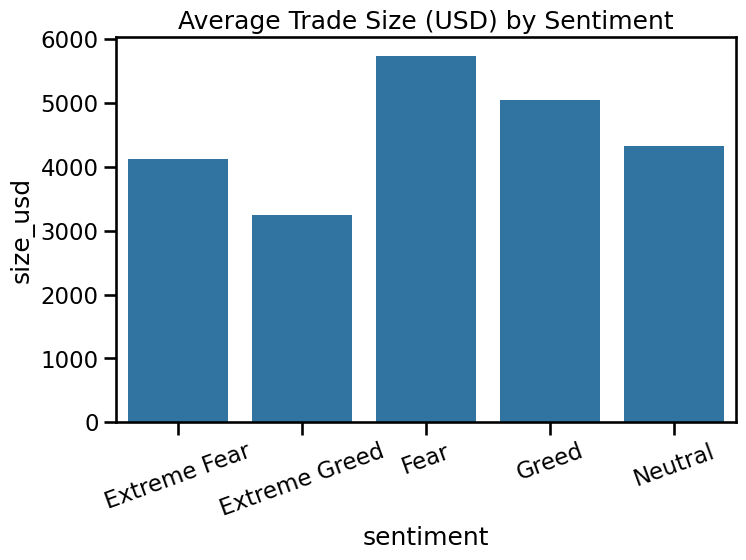

In [13]:
size_summary = df.groupby('sentiment')['size_usd'].mean().reset_index()

sns.barplot(x='sentiment', y='size_usd', data=size_summary)
plt.title("Average Trade Size (USD) by Sentiment")
plt.xticks(rotation=20)
plt.show()


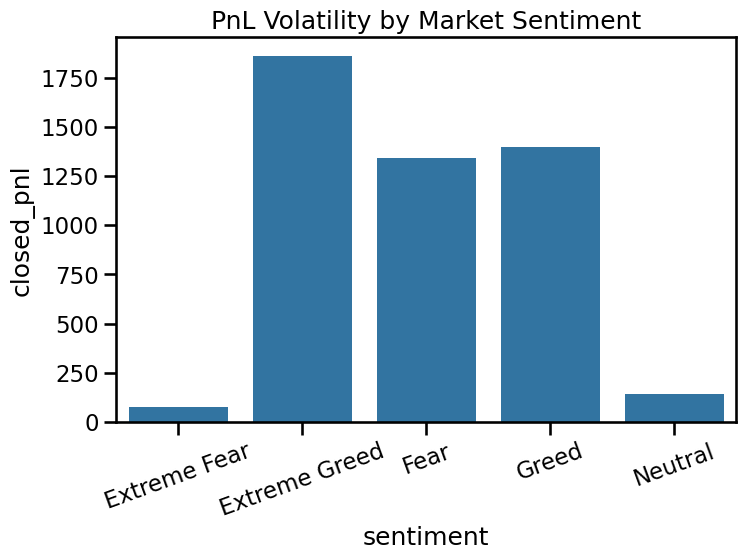

In [14]:
volatility = df.groupby('sentiment')['closed_pnl'].std().reset_index()

sns.barplot(x='sentiment', y='closed_pnl', data=volatility)
plt.title("PnL Volatility by Market Sentiment")
plt.xticks(rotation=20)
plt.show()


In [16]:
sentiment_summary.to_csv(
    r"D:\projects\trader-behavior-vs-market-sentiment\dataclean_analysis\sentiment_summary.csv",
    index=False
)


In [17]:
risk_free_rate = 0

sharpe = df.groupby('sentiment')['closed_pnl'].apply(
    lambda x: (x.mean() - risk_free_rate) / x.std()
).reset_index(name='sharpe_ratio')

sharpe


,sentiment,sharpe_ratio
0,Extreme Fear,0.024654
1,Extreme Greed,0.110561
2,Fear,0.095570
3,Greed,0.038578
4,Neutral,0.189504


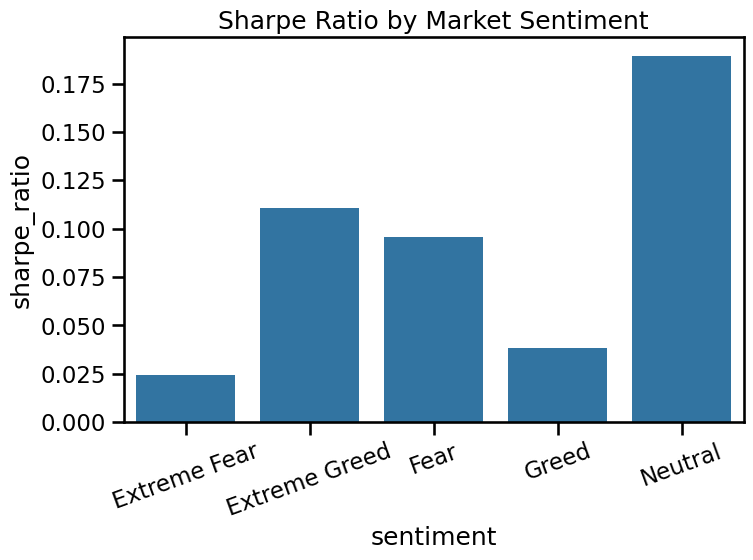

In [18]:
sns.barplot(x='sentiment', y='sharpe_ratio', data=sharpe)
plt.title("Sharpe Ratio by Market Sentiment")
plt.xticks(rotation=20)
plt.show()


In [19]:
win_rate = df.groupby('sentiment').apply(
    lambda x: (x['closed_pnl'] > 0).mean()
).reset_index(name='win_rate')

win_rate


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_20712\974087044.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate = df.groupby('sentiment').apply(


,sentiment,win_rate
0,Extreme Fear,0.292777
1,Extreme Greed,0.553282
2,Fear,0.381787
3,Greed,0.435707
4,Neutral,0.494920


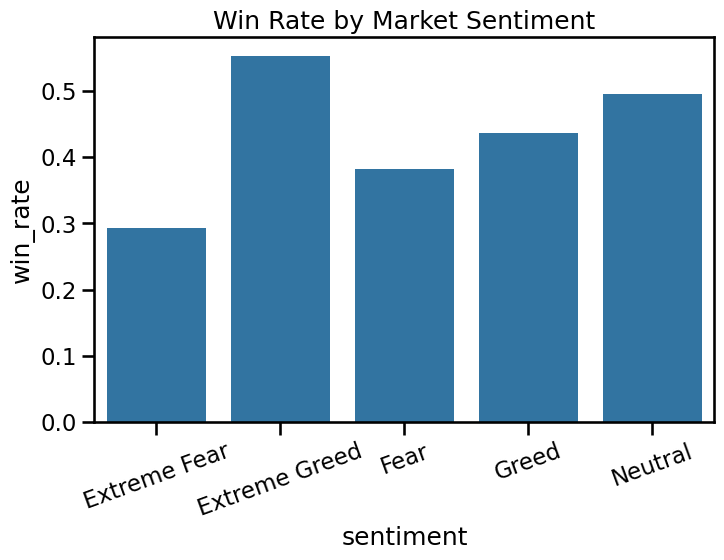

In [20]:
sns.barplot(x='sentiment', y='win_rate', data=win_rate)
plt.title("Win Rate by Market Sentiment")
plt.xticks(rotation=20)
plt.show()


In [21]:
def max_drawdown(pnl_series):
    cumulative = pnl_series.cumsum()
    running_max = cumulative.cummax()
    drawdown = cumulative - running_max
    return drawdown.min()

drawdown = df.groupby('sentiment')['closed_pnl'].apply(
    max_drawdown
).reset_index(name='max_drawdown')

drawdown


,sentiment,max_drawdown
0,Extreme Fear,-9230.965102
1,Extreme Greed,-108604.496278
2,Fear,-99853.030802
3,Greed,-175611.000056
4,Neutral,-3996.496484
